In [141]:
import pandas as pd
import numpy as np
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import monotonically_increasing_id, udf
from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")

import schemas
import tools

# 1.Methods
## load

In [142]:
def load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def load_parquet_from_weather_toPandas(path, schema:StructType = None):
    """
    load apache parquet file
    """
    weather = load_parquet(path) \
                    .withColumnRenamed("__index_level_0__", "TIME") \
                    .dropna() \
                    .withColumn("id", monotonically_increasing_id())
    weather.createOrReplaceTempView("weather_temp")
    weather_dic = spark.sql("select * from weather_temp where id in (select max(id) as id from weather_temp group by TIME)").toPandas()
    return weather_dic

def load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    # return sqlContext.read.schema(schema).csv(path, sep=";", header=True, schema=schema) if schema is not None else sqlContext.read.schema(schema).csv(path, sep=";", header=True)
    return sqlContext.read.csv(path, sep=",", header=True, schema=schema)


## UDF

In [143]:
def udf_by_grid(df:pd.DataFrame, type = FloatType()):
    return udf(lambda g, t: list(df[df['TIME'] == t[:14]+'00:00'][g])[0], type)

def udf_by_ws():
    schema = StructType([
        StructField("u_interp", FloatType(), True),
        StructField("v_interp", FloatType(), True)
    ])
    return udf(lambda s1, d1, s2, d2, z: tools.wind_interp(s1, d1, s2, d2, z), schema)

def udf_by_tmp():
    schema = StructType([
        StructField("tmp_interp", FloatType(), True),
    ])
    return udf(lambda t1, t2, z: tools.tmp_interp(t1, t2, z), schema)

In [144]:
def udf_regist():
    udf_type = udf(lambda x: {"H": 1.0, "W": 2.0, "P": 3.0, "M": 4.0}.get(x, 0.0), FloatType())
    udf_placement = udf(lambda x: {"LAND": 1.0, "HAV": 2.0}.get(x, 0.0), FloatType())

    udf_month = udf(lambda x: int(x[5:7]), IntegerType())
    udf_hour = udf(lambda x: int(x[11:13]), IntegerType())
    udf_ws10  = udf_by_grid(ws10_dic, FloatType())
    udf_ws100  = udf_by_grid(ws100_dic, FloatType())
    udf_wd10  = udf_by_grid(wd10_dic, IntegerType())
    udf_wd100  = udf_by_grid(wd100_dic, IntegerType())
    udf_ws_interp  = udf_by_ws()
    return udf_type, udf_placement, udf_month, udf_hour, udf_ws10, udf_ws100, udf_wd10, udf_wd100, udf_ws_interp

## Aggregate

In [145]:
def aggregate(df, join_df):
    df = df.join(join_df, on="GSRN") \
                    .select("GSRN", "TIME_CET", "Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "Slope", "roughness", "VAERDI","grid")

    df = df.withColumn("month", udf_month(df.TIME_CET)) \
                .withColumn("hour", udf_hour(df.TIME_CET)) \
                .withColumn("ws10", udf_ws10(df.grid, df.TIME_CET)) \
                .withColumn("ws100", udf_ws100(df.grid, df.TIME_CET)) \
                .withColumn("wd10", udf_wd10(df.grid, df.TIME_CET)) \
                .withColumn("wd100", udf_wd100(df.grid, df.TIME_CET))

                # .withColumn("tmp2", udf_tmp2(df.grid, df.TIME_CET)) \
                # .withColumn("tmp100", udf_tmp100(df.grid, df.TIME_CET))
    return df

def aggregate_with_interp(df, join_df):
    df = aggregate(df, join_df)
    df = df.withColumn("wsCol", \
                udf_ws_interp(df.ws10, df.wd10, df.ws100, df.wd100, df.Navhub_height)) \
                .select("GSRN", "TIME_CET", "month", "hour", "Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "Slope", "roughness", "VAERDI", "wsCol.u_interp", "wsCol.v_interp")
    return df

# 2.Data Preprocessing

In [146]:
# initialise sparkContext\
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("WindTurbine") \
    .config("spark.executor.memory", "8g") \
    .config("spark.cores.max", "4") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

## Settlement

In [147]:
 # to read parquet file
settlement = load_parquet("data/ITU_DATA/settlement/2019.parquet", schemas.settlement_schema)
settlement = settlement.dropna(subset =["VAERDI"]) \
            .withColumn("VAERDI", settlement["VAERDI"].cast("float"))
            # .where("TIME_CET like '%:00:%'")
settlement.persist()

DataFrame[GSRN: string, VAERDI: float, TIME_CET: string]

In [ ]:
settlement.printSchema()

## Weather
from ENetNEA

In [8]:
ws10_dic = load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_10m.parquet")
ws100_dic = load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_100m.parquet")
wd10_dic = load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_10m.parquet")
wd100_dic = load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_100m.parquet")

In [9]:
udf_type, udf_placement, udf_month, udf_hour, udf_ws10, udf_ws100, udf_wd10, udf_wd100, udf_ws_interp = udf_regist()

## Windmills

In [10]:
windmill = load_csv("data/windmill_cleaned.csv", schemas.windmills_schema)
# BBR_municipal == 101  copengagen only
windmill = windmill.where("grid != 0") \
            .where("BBR_municipal == 851") \
            .fillna(0.1) \
            .withColumn("Turbine_type", udf_type(windmill.Turbine_type)) \
            .withColumn("Placement", udf_placement(windmill.Placement))
windmill.persist()



DataFrame[GSRN: string, Turbine_type: float, Parent_GSRN: string, BBR_municipal: string, Placement: float, UTM_x: string, UTM_y: string, Capacity_kw: float, Rotor_diameter: float, Navhub_height: float, grid: string, grid_in_range: string, Land_cover: float, Slope: float, roughness: float]

In [150]:
windmill.count()

287

In [ ]:
windmill.printSchema()

# 3.ML Analysis

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

## Windmill self clustering

In [ ]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "Slope", "roughness"]
vec_assembler = VectorAssembler(inputCols=feat_cols, outputCol="features")
windmill = vec_assembler.transform(windmill).select("GSRN", "features", "Navhub_height","grid")

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(windmill)
windmill = scalerModel.transform(windmill)

optimal k = 35

In [ ]:
cost = []
clusters = []

for k in range(2, 20):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k, seed=1)
    model = kmeans.fit(windmill)
    cost.append(model.computeCost(windmill))
    clusters.append(k)

# Plot the cost
df_cost = pd.DataFrame(cost)
df_cost.columns = ["cost"]
df_cost.insert(0, 'cluster', clusters)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
kmean = KMeans(featuresCol='scaledFeatures', k=6, seed=1)
model = kmean.fit(windmill)
windmill = model.transform(windmill).withColumnRenamed("prediction", "cluster").select("GSRN", "cluster","Navhub_height", "grid")
windmill.persist()

## Predicte with Weather

In [48]:
train = settlement.where("TIME_CET not like '2019-03-31 02%'").where("TIME_CET not like '2019-12-30%'") \
        .sample(fraction=0.001, seed=5)
test = settlement.where("TIME_CET like '2019-12-30%'")
train.persist()

DataFrame[GSRN: string, VAERDI: float, TIME_CET: string]

In [49]:
train = aggregate_with_interp(train, windmill)
test = aggregate_with_interp(test, windmill)

In [ ]:
train = train.where("VAERDI > 50")

In [13]:
train.count()

2198

# SparkTorch

In [ ]:
from sparktorch import serialize_torch_obj, SparkTorch
import torch
import torch.nn as nn
from pyspark.ml.pipeline import Pipeline

In [ ]:
network = nn.Sequential(
    nn.Linear(4, 50),
    nn.LeakyReLU(),
    nn.Linear(50, 50),
    nn.LeakyReLU(),d
    nn.Linear(50, 1),
    nn.Softmax(dim=1)
)

In [ ]:
# Build the pytorch object
torch_obj = serialize_torch_obj(
    model=network,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.05
)

In [ ]:
# Setup features
feat_cols = ["month", "hour", "cluster", "u_interp", "v_interp"]
vec_assembler = VectorAssembler(inputCols=feat_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
# Create a SparkTorch Model with torch distributed. Barrier execution is on by default for this mode.
spark_model = SparkTorch(
    inputCol='scaledFeatures',
    labelCol='VAERDI',
    predictionCol='predictions',
    torchObj=torch_obj,
    iters=50,
    verbose=1
)

# Can be used in a pipeline and saved.
p = Pipeline(stages=[vec_assembler, scaler, spark_model]).fit(train)

# pyTorch

In [50]:
train_pd = train.toPandas()

In [15]:
test_pd = test.toPandas()

In [124]:
feat_cols = ["month", "hour","Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "Slope", "roughness","u_interp", "v_interp"]
x_train = train_pd[feat_cols]
y_train = train_pd[["VAERDI"]]
x_test = test_pd[feat_cols]
y_test = test_pd[["VAERDI"]]
timeline = test_pd[["TIME_CET"]]

In [125]:
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
dtype = torch.float

In [127]:
x_train_tensor = torch.tensor(x_train, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)

y_train_tensor = torch.tensor(y_train.values, dtype = dtype)
y_test_tensor = torch.tensor(y_test.values, dtype = dtype)

In [128]:
x_train_tensor.shape, y_train_tensor.shape

(torch.Size([4358, 11]), torch.Size([4358, 1]))

In [129]:
input_size = 11
output_size = 1
hidden_size = 300

In [130]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = self.fc3(x)

    return x

In [131]:
model = Net()

In [132]:
# def initialize_weights(m):
#     if isinstance(m, torch.nn.Linear):
#         m.bias.data.fill_(0.5)

# model.apply(initialize_weights)

In [133]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),lr=0.05)

# nn.MSELoss() is implemented by default as: ((input-target)**2).mean()
loss_fn = torch.nn.MSELoss()

In [134]:
epoch_data = []
epochs = 1001

In [135]:
for epoch in range(1, epochs):
  optimizer.zero_grad()
  y_pred = model(x_test_tensor)

  loss = loss_fn(y_pred, y_test_tensor)
  loss.backward()

  optimizer.step()

#   _,pred = y_pred_test.data.max(1)

#   accuracy = pred.eq(y_test_tensor.data).sum().item() / y_test.values.size
#   epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])

  if epoch % 100 == 0:
    print('epoch -%d (%d%%) train loss - %.2f ' \
          % (epoch, epoch/203, loss.data.item()))

epoch -100 (0%) train loss - 18595.11 
epoch -200 (0%) train loss - 13715.15 
epoch -300 (1%) train loss - 11314.45 
epoch -400 (1%) train loss - 8804.97 
epoch -500 (2%) train loss - 8113.81 
epoch -600 (2%) train loss - 7868.84 
epoch -700 (3%) train loss - 7417.65 
epoch -800 (3%) train loss - 7111.01 
epoch -900 (4%) train loss - 6900.56 
epoch -1000 (4%) train loss - 6788.68 


In [136]:
y_pred_tensor = model(x_test_tensor)
y_pred = y_pred_tensor.detach().numpy()

In [137]:
y_test["pred"] = pd.Series(y_pred.tolist()).apply(lambda x: x[0])
y_test["time"] = pd.Series(timeline["TIME_CET"])
y_test = y_test.groupby(y_test["time"]).agg({"VAERDI":lambda x:sum(x), "pred":lambda x:sum(x)}).reset_index()

In [138]:
y_pred

array([[ 95.991066],
       [ 95.991066],
       [ 95.991066],
       ...,
       [165.81935 ],
       [165.81935 ],
       [165.81935 ]], dtype=float32)

In [139]:
y_test

,time,VAERDI,pred
0,2019-12-30 00:00:00,33381.800781,32739.750996
1,2019-12-30 00:15:00,32633.039062,32262.915028
2,2019-12-30 00:30:00,32579.611328,32262.915028
3,2019-12-30 00:45:00,32758.703125,32262.915028
4,2019-12-30 01:00:00,33149.609375,32247.656982
...,...,...,...
91,2019-12-30 22:45:00,26092.416016,25527.488495
92,2019-12-30 23:00:00,30023.369141,27003.749580
93,2019-12-30 23:15:00,29517.003906,26669.523293
94,2019-12-30 23:30:00,29742.281250,26669.523293


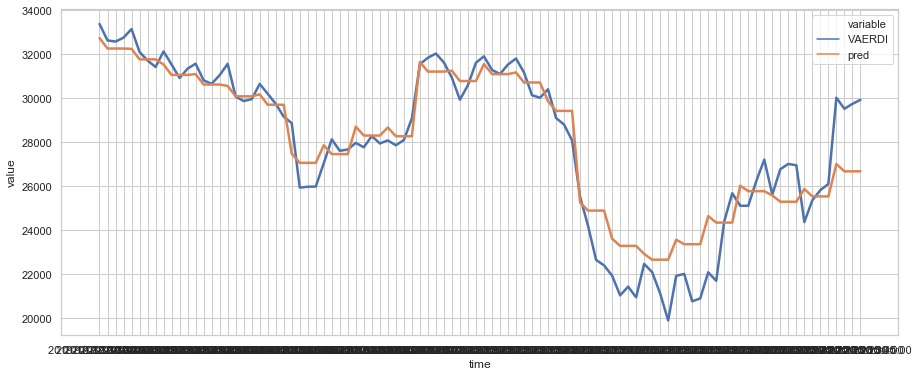

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(y_test, ['time']), hue='variable',linewidth=2.5)